Loaded 200 data points
First few x values: [-97.922  41.985  95.654 -60.534 -86.19 ]
First few v values: [-16.41     7.0886  14.671  -14.797  -16.455 ]
Single-fault acceptance rate: 0.10896666666666667
Single-fault posterior means: [45.53472416 36.05335698 18.34031972]
Single-fault posterior stds:  [0.61153888 1.13507709 0.35642496]


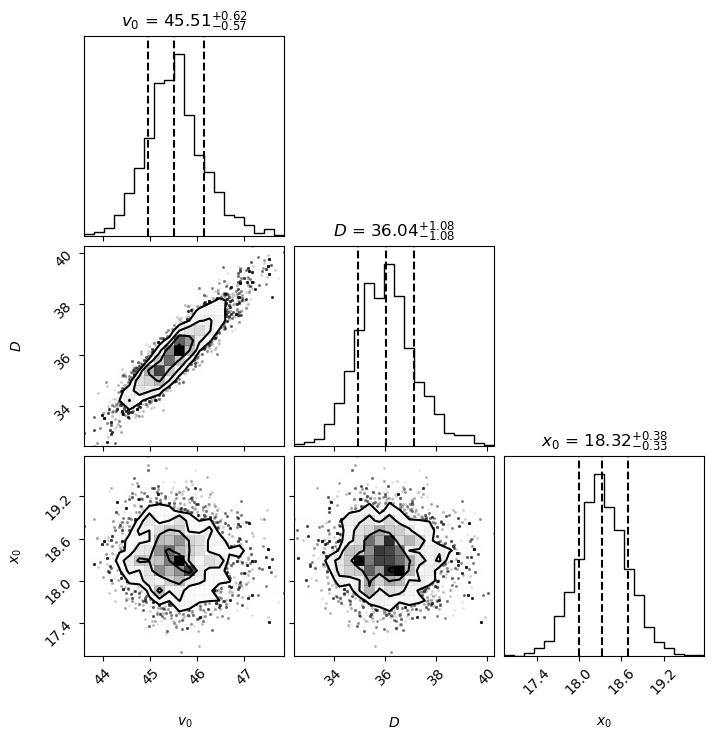

Single-fault: Average RMSE =  1.3951904158351556


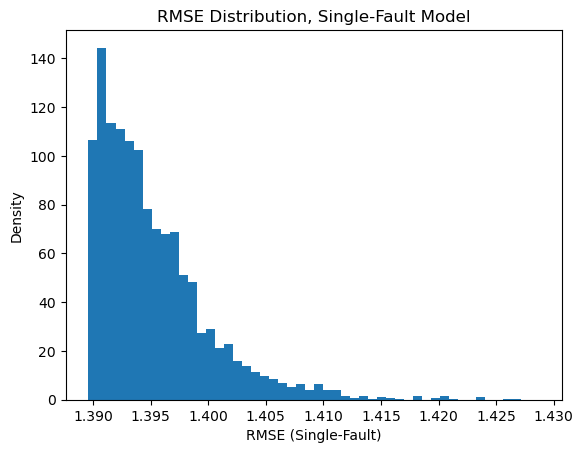

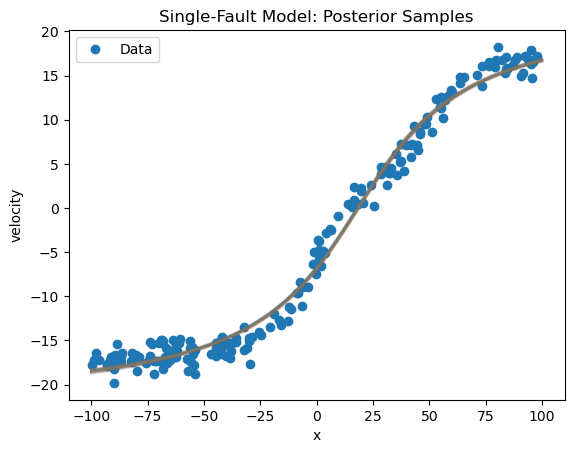

Two-fault acceptance rate: 0.026725
Two-fault posterior means: [23.20250036 14.01281105 -0.37516914 14.35073707 11.90321654 49.06716319]
Two-fault posterior stds:  [0.94755983 1.11626747 0.75813553 0.8321266  1.23752267 1.22738313]


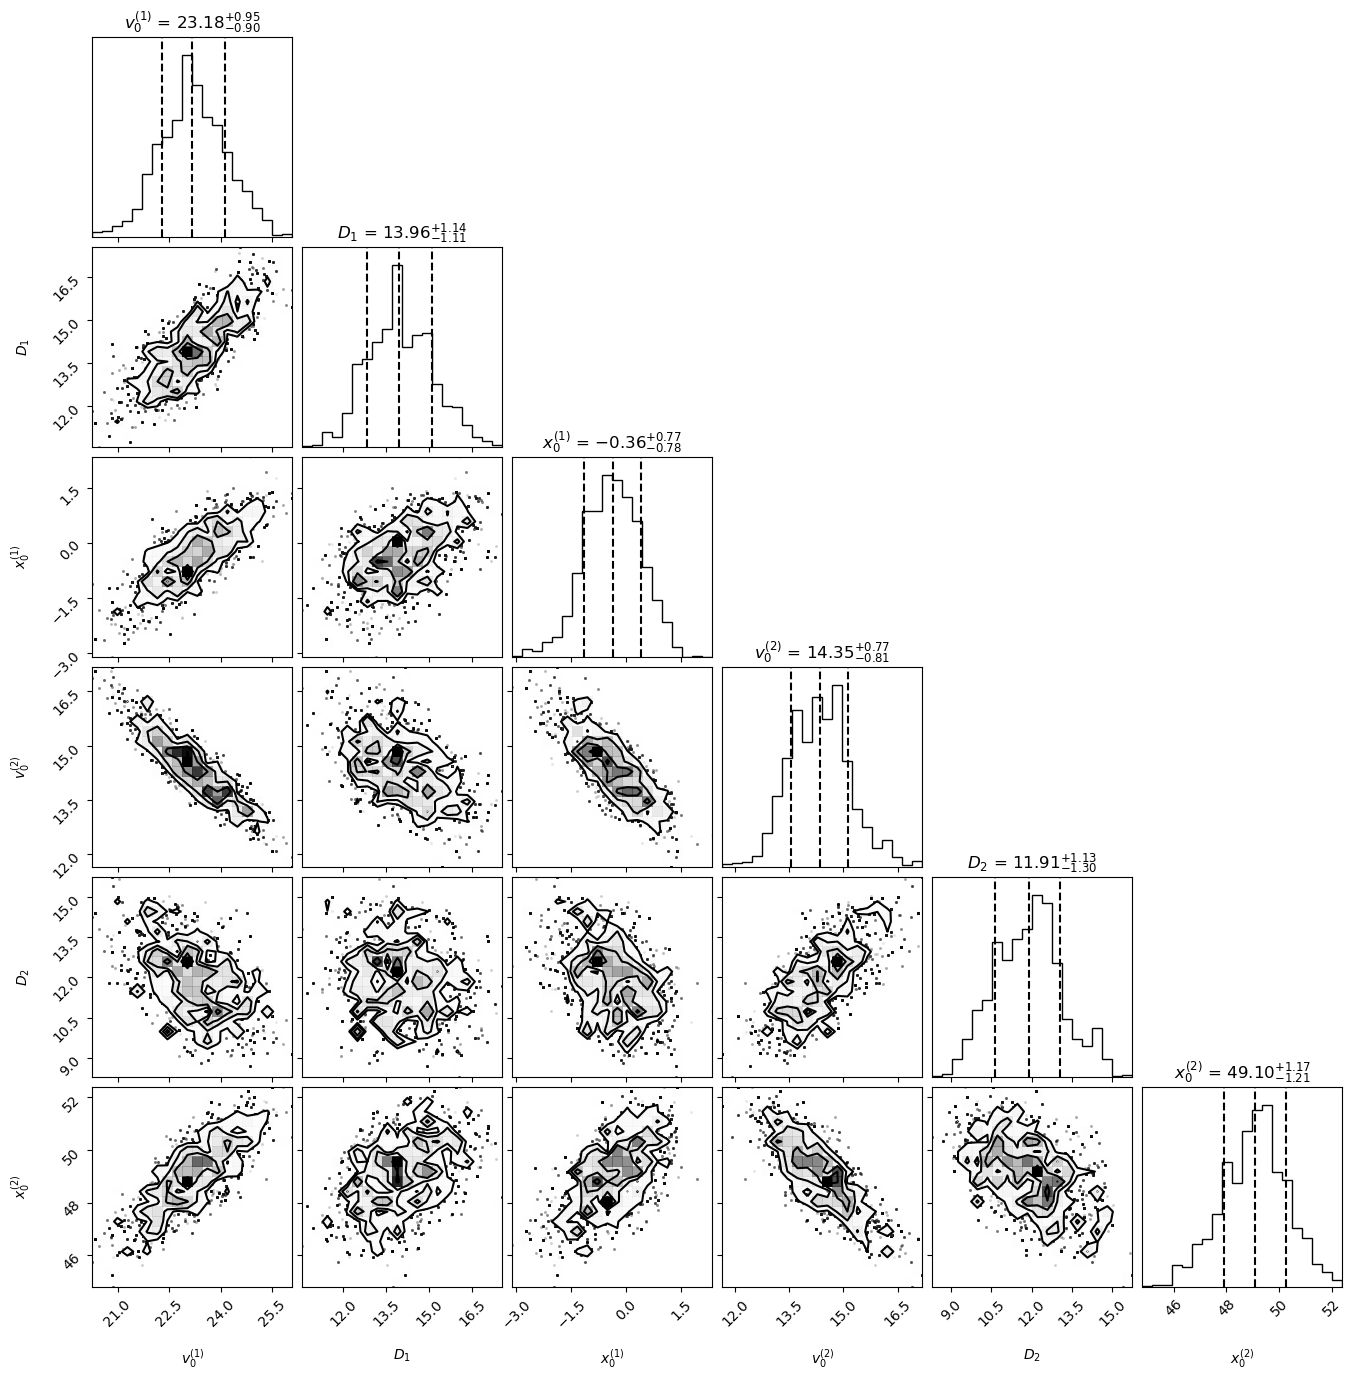

Two-fault: Average RMSE =  0.99325396743746


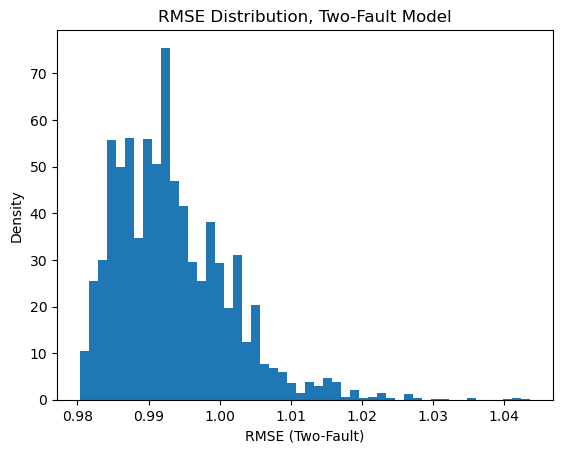

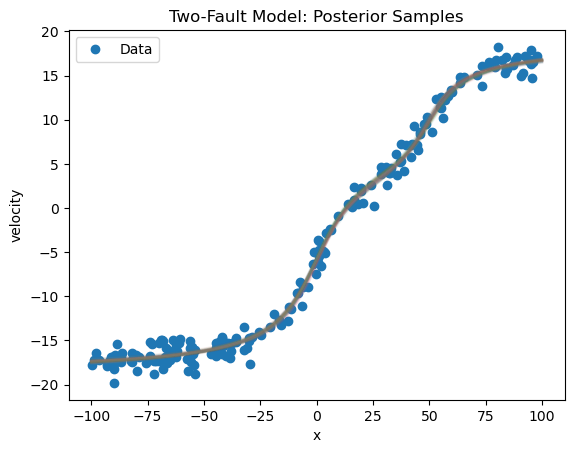

Single-Fault Model mean RMSE: 1.3951904158351556
Two-Fault Model mean RMSE: 0.99325396743746


In [3]:
# MCMC Code to analyse San Andreas Fault based on creep rate data. 

import numpy as np
import matplotlib.pyplot as plt
import corner  # run (!pip install corner) first


# Loading my data with comma as delimiter
data = np.loadtxt("data.txt", delimiter=",")
x_data = data[:, 0]  # Locations (x_j)
y_data = data[:, 1]  # Velocities (v(x_j))
N_y = len(x_data)    # Number of measurements (200)

print(f"Loaded {N_y} data points")
print("First few x values:", x_data[:5])
print("First few v values:", y_data[:5])


sigma = 1.0 # standard deviation of the error.

###############################################################################
# 2) Defining the velocity models
###############################################################################

def velocity_single_fault(x, v0, D, x0): # x0 is the location of the fault
    """
    Single-fault velocity model:

    v(x) = (v0 / pi) * arctan((x - x0)/D)
    """
    return (v0 / np.pi) * np.arctan((x - x0) / D) # v(x) = (v0 / pi) * arctan((x - x0)/D)


def velocity_two_fault(x, v10, D1, x10, v20, D2, x20):
    """
    Two-fault velocity model:

    v(x) = (v10 / pi) * arctan((x - x10)/D1) + (v20 / pi) * arctan((x - x20)/D2)
    """
    term1 = (v10 / np.pi) * np.arctan((x - x10) / D1)
    term2 = (v20 / np.pi) * np.arctan((x - x20) / D2)
    return term1 + term2

###############################################################################
# 3) Defining log-likelihood and log-prior for each model
###############################################################################

def log_likelihood_single_fault(params, x_obs, y_obs):
    """
    Computes the log-likelihood under a Gaussian error model with sigma=1.
    params = [v0, D, x0]
    """
    v0, D, x0 = params

    # Model predictions
    y_model = velocity_single_fault(x_obs, v0, D, x0)

    # Gaussian log-likelihood
    residuals = y_obs - y_model
    # sum of squared errors with sigma=1 => log-likelihood = -0.5 * sum(res^2)
    ll = -0.5 * np.sum(residuals**2 / sigma**2)
    return ll


def log_prior_single_fault(params):
    """
    Uniform prior over:
      v0 in [0, 80], D in [0, 80], x0 in [-50, 50]
    Return -inf if outside these ranges, 0 if inside.
    """
    v0, D, x0 = params
    if not (0 <= v0 <= 80):
        return -np.inf
    if not (0 <= D <= 80):
        return -np.inf
    if not (-50 <= x0 <= 50):
        return -np.inf
    # uniform prior in these intervals => log(prior) = 0 if inside
    return 0.0


def log_likelihood_two_fault(params, x_obs, y_obs):
    """
    Two-fault log-likelihood.  params = [v10, D1, x10, v20, D2, x20].
    """
    v10, D1, x10, v20, D2, x20 = params
    y_model = velocity_two_fault(x_obs, v10, D1, x10, v20, D2, x20)
    residuals = y_obs - y_model
    ll = -0.5 * np.sum(residuals**2 / sigma**2)
    return ll


def log_prior_two_fault(params):
    """
    Uniform prior for:
      v10, v20 in [0, 80]
      D1, D2 in [0, 80]
      x10 in [-20, 20]
      x20 in [30, 80]
    """
    v10, D1, x10, v20, D2, x20 = params
    if not (0 <= v10 <= 80):
        return -np.inf
    if not (0 <= v20 <= 80):
        return -np.inf
    if not (0 <= D1 <= 80):
        return -np.inf
    if not (0 <= D2 <= 80):
        return -np.inf
    if not (-20 <= x10 <= 20):
        return -np.inf
    if not (30 <= x20 <= 80):
        return -np.inf
    return 0.0


###############################################################################
# 4) Random-Walk Metropolis Sampler
###############################################################################

def metropolis_sampler(log_likelihood_func, log_prior_func, initial_guess,
                       step_scale, n_samples, x_obs, y_obs):
    """
    Generic Random-Walk Metropolis sampler.

    log_likelihood_func(params, x_obs, y_obs) -> float
    log_prior_func(params) -> float

    step_scale is either a scalar (if 3D or 6D we might want a vector or a covariance, but
    here for simplicity we keep it as a single scalar step size for each dimension).
    """
    np.random.seed(42)  # can change

    # Initialize
    current_params = np.array(initial_guess, dtype=float)
    dim = len(current_params)

    # Computing current log posterior 
    current_log_like = log_likelihood_func(current_params, x_obs, y_obs)
    current_log_prior = log_prior_func(current_params)
    current_log_posterior = current_log_like + current_log_prior

    chain = np.zeros((n_samples, dim))
    log_posts = np.zeros(n_samples)

    accepted = 0

    for i in range(n_samples):
        # Propose a new point via normal random walk
        proposal = current_params + step_scale * np.random.randn(dim)

        # Evaluate log posterior at proposed point
        proposal_log_prior = log_prior_func(proposal)
        if proposal_log_prior == -np.inf:
            # outside prior range: reject immediately
            chain[i] = current_params
            log_posts[i] = current_log_posterior
            continue

        proposal_log_like = log_likelihood_func(proposal, x_obs, y_obs)
        proposal_log_posterior = proposal_log_like + proposal_log_prior

        # Acceptance probability
        alpha = proposal_log_posterior - current_log_posterior

        if np.log(np.random.rand()) < alpha:
            # Accept
            current_params = proposal
            current_log_posterior = proposal_log_posterior
            current_log_like = proposal_log_like
            current_log_prior = proposal_log_prior
            accepted += 1

        chain[i] = current_params
        log_posts[i] = current_log_posterior

    acceptance_rate = accepted / n_samples
    return chain, log_posts, acceptance_rate


###############################################################################
# 5) Single-fault model
###############################################################################

# Let's pick an initial guess within the prior ranges:
initial_guess_single = [40, 10, 0]   # v0=40, D=10, x0=0 as a naive guess
step_scale_single = 1.0             # tune for acceptance ~ 20-50% is typical
n_samples_single = 30000            # I have seen people choose 100k or more, but I didn't have that time and luxury.

# Run MCMC
chain_single, log_posts_single, acc_rate_single = metropolis_sampler(
    log_likelihood_single_fault,
    log_prior_single_fault,
    initial_guess_single,
    step_scale_single,
    n_samples_single,
    x_data,
    y_data
)

burn_in_single = 5000  # discard first 5000 as "burn-in"
chain_single_post = chain_single[burn_in_single:]
print("Single-fault acceptance rate:", acc_rate_single)

# Posterior means and standard deviations
mean_single = np.mean(chain_single_post, axis=0)
std_single  = np.std(chain_single_post, axis=0)
print("Single-fault posterior means:", mean_single)
print("Single-fault posterior stds: ", std_single)

# Triangle plot (corner plot) for single-fault
fig_corner_single = corner.corner(chain_single_post,
                                  labels=[r"$v_0$", r"$D$", r"$x_0$"],
                                  quantiles=[0.16, 0.5, 0.84],
                                  show_titles=True,
                                  title_fmt=".2f",
                                  title_kwargs={"fontsize": 12})
plt.show()

###############################################################################
# Computing RMSE over the chain for single-fault
###############################################################################

burned_chain_single = chain_single[burn_in_single:]
Ns_single = len(burned_chain_single)
rmse_values_single = np.zeros(Ns_single)

for i in range(Ns_single):
    v0_i, D_i, x0_i = burned_chain_single[i]
    model_pred = velocity_single_fault(x_data, v0_i, D_i, x0_i)
    residuals = (y_data - model_pred) / sigma
    rmse_values_single[i] = np.sqrt(np.mean(residuals**2))

# The "Theoretical" RMSE should be around 1.0 if the model & sigma are correct

print("Single-fault: Average RMSE = ", np.mean(rmse_values_single))

# Plot a histogram of RMSE
plt.figure()
plt.hist(rmse_values_single, bins=50, density=True)
plt.xlabel("RMSE (Single-Fault)")
plt.ylabel("Density")
plt.title("RMSE Distribution, Single-Fault Model")
plt.show()

###############################################################################
# Plot data + a few random posterior draws for single-fault
###############################################################################

x_grid = np.linspace(-100, 100, 400)
plt.figure()
plt.plot(x_data, y_data, 'o', label="Data")
# Plot 100 random samples from posterior
idxs = np.random.choice(len(chain_single_post), 100, replace=False)
for i in idxs:
    v0_i, D_i, x0_i = chain_single_post[i]
    plt.plot(x_grid, velocity_single_fault(x_grid, v0_i, D_i, x0_i), alpha=0.05)
plt.xlabel("x")
plt.ylabel("velocity")
plt.title("Single-Fault Model: Posterior Samples")
plt.legend()
plt.show()

###############################################################################
# 6) Two-fault model
###############################################################################
# initial guess that satisfies the prior constraints:
# [v10, D1, x10, v20, D2, x20]

initial_guess_two = [40, 10, 0, 40, 10, 50]
step_scale_two = 1.0
n_samples_two = 40000

chain_two, log_posts_two, acc_rate_two = metropolis_sampler(
    log_likelihood_two_fault,
    log_prior_two_fault,
    initial_guess_two,
    step_scale_two,
    n_samples_two,
    x_data,
    y_data
)

burn_in_two = 5000
chain_two_post = chain_two[burn_in_two:]
print("Two-fault acceptance rate:", acc_rate_two)

# Posterior means and standard deviations
mean_two = np.mean(chain_two_post, axis=0)
std_two  = np.std(chain_two_post, axis=0)
print("Two-fault posterior means:", mean_two)
print("Two-fault posterior stds: ", std_two)

# Triangle plot (corner plot) for two-fault
labels_two = [r"$v_{0}^{(1)}$", r"$D_1$", r"$x_{0}^{(1)}$",
              r"$v_{0}^{(2)}$", r"$D_2$", r"$x_{0}^{(2)}$"]
fig_corner_two = corner.corner(chain_two_post,
                               labels=labels_two,
                               quantiles=[0.16, 0.5, 0.84],
                               show_titles=True,
                               title_fmt=".2f",
                               title_kwargs={"fontsize": 12})
plt.show()

###############################################################################
# Compute RMSE over the chain for two-fault
###############################################################################
Ns_two = len(chain_two_post)
rmse_values_two = np.zeros(Ns_two)

for i in range(Ns_two):
    v10_i, D1_i, x10_i, v20_i, D2_i, x20_i = chain_two_post[i]
    model_pred = velocity_two_fault(x_data, v10_i, D1_i, x10_i, v20_i, D2_i, x20_i)
    residuals = (y_data - model_pred) / sigma
    rmse_values_two[i] = np.sqrt(np.mean(residuals**2))

print("Two-fault: Average RMSE = ", np.mean(rmse_values_two))

# Plot a histogram of RMSE
plt.figure()
plt.hist(rmse_values_two, bins=50, density=True)
plt.xlabel("RMSE (Two-Fault)")
plt.ylabel("Density")
plt.title("RMSE Distribution, Two-Fault Model")
plt.show()

###############################################################################
# Plot data + a few random posterior draws for two-fault
###############################################################################
plt.figure()
plt.plot(x_data, y_data, 'o', label="Data")
idxs_two = np.random.choice(len(chain_two_post), 100, replace=False)
for i in idxs_two:
    v10_i, D1_i, x10_i, v20_i, D2_i, x20_i = chain_two_post[i]
    plt.plot(x_grid,
             velocity_two_fault(x_grid, v10_i, D1_i, x10_i, v20_i, D2_i, x20_i),
             alpha=0.05)
plt.xlabel("x")
plt.ylabel("velocity")
plt.title("Two-Fault Model: Posterior Samples")
plt.savefig('Two-Fault.png')
plt.legend()
plt.show()

###############################################################################
# Compare the models
###############################################################################
print("Single-Fault Model mean RMSE:", np.mean(rmse_values_single))
print("Two-Fault Model mean RMSE:", np.mean(rmse_values_two))
